In [47]:
from coniferest.isoforest import IsolationForest
from coniferest.pineforest import PineForest
from coniferest.label import Label
from coniferest.session import Session

import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from progressbar import progressbar

## Data

In [3]:
# read data
data = pd.read_parquet('/media/snad/data/gz2/astronomaly.parquet')

In [4]:
# remove columns related to ID and anomaly tag
data_use = data[list(data.keys())[:-2]]

In [5]:
# check if all elements are floats
all_floats = data_use.dtypes.apply(lambda x: x.kind == "f").all()
print(all_floats)

True


## Isolation Forest

In [6]:
# fit a normal Isolation forest
model = IsolationForest(random_seed=np.random.randint(10**9))
model.fit(data_use.values)

In [7]:
scores = model.score_samples(data_use.values)

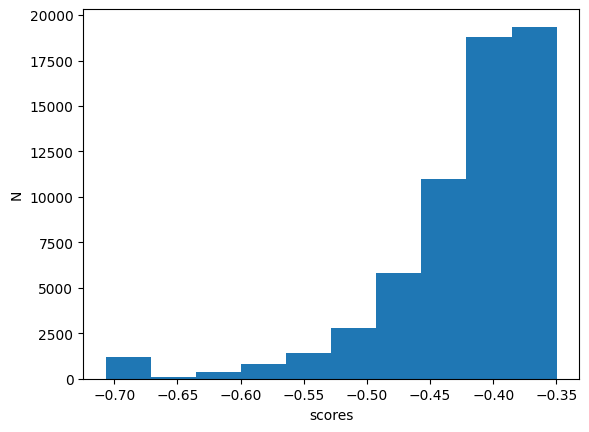

In [8]:
plt.hist(scores)
plt.xlabel('scores')
plt.ylabel('N')
plt.show()

In [9]:
# get the 100 most anomalous objects
order = np.argsort(scores)

In [11]:
# get labels for 100 most anomalous objects
labels = data['anomaly'].values[order[:100]]

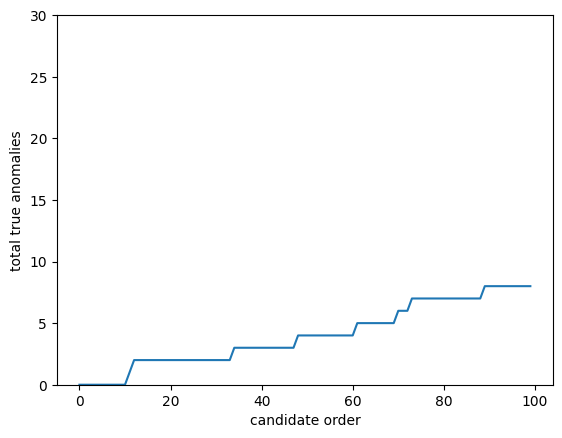

In [14]:
# plot the result in order

y = [sum(labels[:i]) for i in range(len(labels))]
x = np.arange(len(labels))

plt.figure()
plt.plot(x,y)
plt.xlabel('candidate order')
plt.ylabel('total true anomalies')
plt.ylim(0,30)
plt.show()

Something between 5 and 6 is consistent with the first version of this exercise, which is in the overleaf

In [16]:
# run 200 in a role
n = 200
y_all = []

for i in progressbar(range(n)):
    model = IsolationForest(random_seed=np.random.randint(10**9))
    model.fit(data_use.values)
    scores = model.score_samples(data_use.values)
    order = np.argsort(scores)
    labels = data['anomaly'].values[order[:100]]
    y = [sum(labels[:i]) for i in range(len(labels))]
    y_all.append(y)

100% (200 of 200) |######################| Elapsed Time: 0:00:43 Time:  0:00:430003


In [17]:
y_all = np.array(y_all)

In [35]:
# get numbers for plotting
ymax = [np.percentile(y_all[:,i],95) for i in range(y_all.shape[1])]
ymin = [np.percentile(y_all[:,i], 5) for i in range(y_all.shape[1])]
ymedian = [np.median(y_all[:,i]) for i in range(y_all.shape[1])]

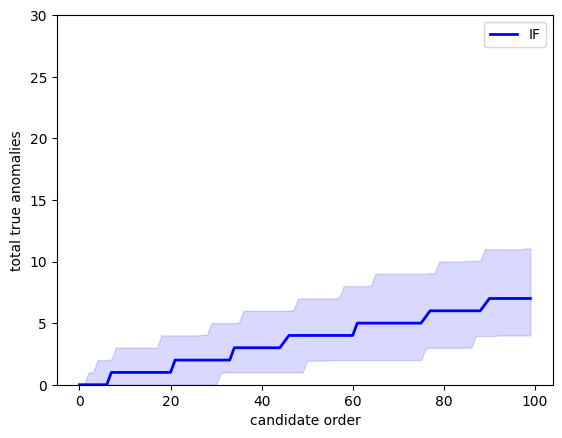

In [45]:
# plot intervals

plt.figure()
ax = plt.subplot(1,1,1)
ax.plot(x, ymedian, color='blue', lw=2, label='IF')
ax.fill_between(x, ymin, ymax, color='blue', alpha=0.15)
plt.xlabel('candidate order')
plt.ylabel('total true anomalies')
plt.ylim(0,30)
plt.legend()
plt.show()

## PineForest

In [79]:
# set up to use already known labels
def my_on_refit_callback(session):
    print('Refitting model with known labels:')
    print(session.known_labels)

def my_decision_callback(metadata, data, session):
    """Get data from the known table."""
    return Label.ANOMALY if metadata[1] else Label.REGULAR

def my_on_decision_callback(metadata, data, session):
    print(f'Decision made for {metadata}: {session.last_decision}.')

def terminate_after_2_anomalies(metadata, data, session):
    if session.known_anomalies.size >= 2:
        session.terminate()

class RecordCallback:
    def __init__(self):
        self.records = []

    def __call__(self, metadata, data, session):
        self.records.append(f'{metadata} -> {session.last_decision}')

    def print_report(self):
        print('Records:')
        print('\n'.join(self.records))


record_callback = RecordCallback()

metadata = data.values[:,-2:]
model = PineForest(random_seed=42)

session = Session(
    data=data_use.values,
    metadata=metadata,
    model=model,
    decision_callback=my_decision_callback,
    # We can give an only function/callable as a callback
    on_refit_callbacks=my_on_refit_callback,
    # Or a list of callables
    on_decision_callbacks=[
        my_on_decision_callback,
        record_callback,
        terminate_after_2_anomalies,
    ],
)
session.run()

Refitting model with known labels:
{}
Decision made for [701930 False]: 1.
Refitting model with known labels:
{np.int64(41271): <Label.REGULAR: 1>}
Decision made for [808755 False]: 1.
Refitting model with known labels:
{np.int64(41271): <Label.REGULAR: 1>, np.int64(48677): <Label.REGULAR: 1>}
Decision made for [283268 False]: 1.
Refitting model with known labels:
{np.int64(41271): <Label.REGULAR: 1>, np.int64(48677): <Label.REGULAR: 1>, np.int64(12408): <Label.REGULAR: 1>}
Decision made for [373505 True]: -1.
Refitting model with known labels:
{np.int64(41271): <Label.REGULAR: 1>, np.int64(48677): <Label.REGULAR: 1>, np.int64(12408): <Label.REGULAR: 1>, np.int64(18605): <Label.ANOMALY: -1>}
Decision made for [601610 True]: -1.


In [81]:
len(session.known_labels)

5